# XGB Test

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Load Data and Process
train = pd.read_csv("data/train.csv")
target = train['target']
ft_train = train.drop(['target', 'ID_code'], axis=1)

In [3]:
ft_train.columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

# Data Splitting

In [4]:
# preproc things
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
train_scaler = StandardScaler() 
X_scale = train_scaler.fit_transform(ft_train)
X_train, X_test, y_train, y_test = \
        train_test_split(X_scale, target, test_size=.4, 
                         random_state=42)

In [6]:
# test the DMatrix
import xgboost as xgb

In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)

# Fit XGB

In [8]:
from xgboost import XGBClassifier

In [9]:
# adding gpu bits
param = {}
param['gpu_id'] = 1
param['tree_method'] = 'gpu_hist'
model = XGBClassifier(**param)

In [10]:
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [11]:
#model.evals_result()

In [17]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

In [22]:
y_pred_prob.shape

(80000, 2)

In [24]:
# as per the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
# the roc score needs the prediction probability of the class with the greater value 
# so in this case is the probability of getting a 1
y_pred_roc = y_pred_prob[:,1]
y_pred_roc.shape

(80000,)

In [13]:
from sklearn.metrics import roc_auc_score

In [25]:
roc_auc_score(y_test, y_pred_roc)

0.8537502873990437

In [30]:
# lets run on the actual test set and submit just to see what my score is like
sub_test = pd.read_csv("data/test.csv")
sub_ft_test = sub_test.drop(['ID_code'], axis=1)
X_submit_scale = train_scaler.transform(sub_ft_test)
pred_results = model.predict(X_submit_scale)

In [40]:
submit_frame = sub_test['ID_code'].copy().to_frame()
submit_frame['target'] = pred_results 

In [43]:
submit_frame.to_csv('submit_test.csv', index=False)

In [ ]:
# returned 

# Confusion Matrix

In [10]:
from sklearn.metrics import plot_confusion_matrix

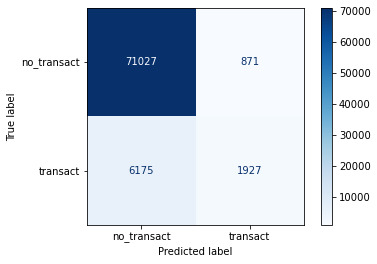

In [11]:
class_names = ['no_transact', 'transact']
plot_confusion_matrix(model, X_test, y_test,
                     display_labels=class_names,
                     cmap=plt.cm.Blues)

# Hyperparam Tuning XGB

In [12]:
from ray import tune
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from ray.tune.schedulers import ASHAScheduler
import xgboost as xgb
#from tune_sklearn import TuneGridSearchCV

In [13]:
import ray
ray.init(dashboard_host="0.0.0.0")

2020-12-03 11:16:36,601	WARNING utils.py:569 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2020-12-03 11:16:37,122	INFO services.py:1090 -- View the Ray dashboard at http://172.17.0.3:8265


{'node_ip_address': '172.17.0.3',
 'raylet_ip_address': '172.17.0.3',
 'redis_address': '172.17.0.3:6379',
 'object_store_address': '/tmp/ray/session_2020-12-03_11-16-36_592307_110/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-03_11-16-36_592307_110/sockets/raylet',
 'webui_url': '172.17.0.3:8265',
 'session_dir': '/tmp/ray/session_2020-12-03_11-16-36_592307_110',
 'metrics_export_port': 57165,
 'node_id': 'c03d49def53567f509f3433afc41a714ad4063cb'}

In [25]:
def train_santander(config: dict):
    # Load Data and Process
    train = pd.read_csv("/home/jovyan/work/ray_experiments/data/train.csv")
    target = train['target']
    ft_train = train.drop(['target', 'ID_code'], axis=1)
    
    X_scale = StandardScaler().fit_transform(ft_train)
    X_train, X_test, y_train, y_test = \
        train_test_split(X_scale, target, test_size=.4, 
                         random_state=42)
    
    # reformat to xgb
    train_set = xgb.DMatrix(X_train, label=y_train)
    test_set = xgb.DMatrix(X_test, label=y_test)
    
    xgb.train(config,
             train_set,
             evals=[(test_set, "eval")],
             callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])

In [26]:
search_space = {
    "n_estimators": 500,
    "tree_method": "gpu_hist",
    "objective": "binary:logistic",
    "eval_metric": ["auc", "error"],
    "eta": tune.loguniform(0.01, 0.2),
    "min_child_weight": tune.randint(1, 10),
    "max_depth": tune.randint(3, 10),
    "gamma": tune.uniform(0, 20),
    "subsample": tune.loguniform(0.5,1),
    "colsample_bytree": tune.loguniform(0.5,1),
}

In [27]:
scheduler = ASHAScheduler(
        max_t=50,  # 10 training iterations
        grace_period=1,
        reduction_factor=2)

In [28]:
analysis = tune.run(
        train_santander,
        metric="eval-auc",
        mode="max",
        # You can add "gpu": 0.1 to allocate GPUs
        resources_per_trial={"cpu": 8, "gpu": 0.5},
        config=search_space,
        num_samples=30,
        scheduler=scheduler)

2020-12-03 11:40:33,336	WARNING function_runner.py:539 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample
train_santander_5a557_00000,RUNNING,,0.734882,0.0306503,5.71315,3,3,0.523586


(pid=197) [11:40:41] WARNING: ../src/learner.cc:516: 
(pid=197) Parameters: { n_estimators } might not be used.
(pid=197) 
(pid=197)   This may not be accurate due to some parameters are only used in language bindings but
(pid=197)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=197)   verification. Please open an issue if you find above cases.
(pid=197) 
(pid=197) 


Result for train_santander_5a557_00000:
  date: 2020-12-03_11-40-41
  done: false
  eval-auc: 0.596031
  eval-error: 0.102312
  experiment_id: ad5cb8ea58d0455b9b6b54ebea957792
  experiment_tag: 0_colsample_bytree=0.73488,eta=0.03065,gamma=5.7131,max_depth=3,min_child_weight=3,subsample=0.52359
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 197
  should_checkpoint: true
  time_since_restore: 7.164073705673218
  time_this_iter_s: 7.164073705673218
  time_total_s: 7.164073705673218
  timestamp: 1606995641
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00000
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00000,RUNNING,172.17.0.3:197,0.734882,0.0306503,5.71315,3,3,0.523586,1,7.16407,0.596031,0.102312
train_santander_5a557_00001,PENDING,,0.654324,0.0532394,2.95518,9,8,0.624054,,,,


(pid=197) [0]	eval-auc:0.59603	eval-error:0.10231
(pid=197) [1]	eval-auc:0.62932	eval-error:0.10132
(pid=197) [2]	eval-auc:0.64956	eval-error:0.10130
(pid=197) [3]	eval-auc:0.65703	eval-error:0.10128
(pid=197) [4]	eval-auc:0.66180	eval-error:0.10128
(pid=197) [5]	eval-auc:0.67718	eval-error:0.10128
(pid=197) [6]	eval-auc:0.67729	eval-error:0.10128
(pid=197) [7]	eval-auc:0.67633	eval-error:0.10128
(pid=197) [8]	eval-auc:0.67599	eval-error:0.10128
(pid=197) [9]	eval-auc:0.67944	eval-error:0.10128


(pid=204) [11:40:51] WARNING: ../src/learner.cc:516: 
(pid=204) Parameters: { n_estimators } might not be used.
(pid=204) 
(pid=204)   This may not be accurate due to some parameters are only used in language bindings but
(pid=204)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=204)   verification. Please open an issue if you find above cases.
(pid=204) 
(pid=204) 


Result for train_santander_5a557_00001:
  date: 2020-12-03_11-40-52
  done: false
  eval-auc: 0.646406
  eval-error: 0.10745
  experiment_id: bb34d7e12b79496e8c494a3deca7884b
  experiment_tag: 1_colsample_bytree=0.65432,eta=0.053239,gamma=2.9552,max_depth=9,min_child_weight=8,subsample=0.62405
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 204
  should_checkpoint: true
  time_since_restore: 8.37003469467163
  time_this_iter_s: 8.37003469467163
  time_total_s: 8.37003469467163
  timestamp: 1606995652
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00001
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00001,RUNNING,172.17.0.3:204,0.654324,0.0532394,2.95518,9,8,0.624054,1,8.37003,0.646406,0.10745
train_santander_5a557_00002,PENDING,,0.99057,0.0604132,14.5206,6,7,0.992367,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275


(pid=204) [0]	eval-auc:0.64641	eval-error:0.10745
(pid=204) [1]	eval-auc:0.68931	eval-error:0.10141
(pid=204) [2]	eval-auc:0.70929	eval-error:0.10114
(pid=204) [3]	eval-auc:0.72301	eval-error:0.10114
(pid=204) [4]	eval-auc:0.73411	eval-error:0.10118
(pid=204) [5]	eval-auc:0.74082	eval-error:0.10119
(pid=204) [6]	eval-auc:0.74523	eval-error:0.10126
(pid=204) [7]	eval-auc:0.74825	eval-error:0.10129
(pid=204) [8]	eval-auc:0.74985	eval-error:0.10124
(pid=204) [9]	eval-auc:0.75192	eval-error:0.10122


(pid=194) [11:41:01] WARNING: ../src/learner.cc:516: 
(pid=194) Parameters: { n_estimators } might not be used.
(pid=194) 
(pid=194)   This may not be accurate due to some parameters are only used in language bindings but
(pid=194)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=194)   verification. Please open an issue if you find above cases.
(pid=194) 
(pid=194) 


Result for train_santander_5a557_00002:
  date: 2020-12-03_11-41-02
  done: false
  eval-auc: 0.640417
  eval-error: 0.102613
  experiment_id: 88ebe4c1462141b29fb837e335886049
  experiment_tag: 2_colsample_bytree=0.99057,eta=0.060413,gamma=14.521,max_depth=6,min_child_weight=7,subsample=0.99237
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 194
  should_checkpoint: true
  time_since_restore: 8.204849004745483
  time_this_iter_s: 8.204849004745483
  time_total_s: 8.204849004745483
  timestamp: 1606995662
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00002
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00002,RUNNING,172.17.0.3:194,0.99057,0.0604132,14.5206,6,7,0.992367,1,8.20485,0.640417,0.102613
train_santander_5a557_00003,PENDING,,0.876263,0.0288851,14.8686,3,7,0.506137,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225


(pid=194) [0]	eval-auc:0.64042	eval-error:0.10261
Result for train_santander_5a557_00002:
  date: 2020-12-03_11-41-02
  done: true
  eval-auc: 0.656935
  eval-error: 0.101375
  experiment_id: 88ebe4c1462141b29fb837e335886049
  experiment_tag: 2_colsample_bytree=0.99057,eta=0.060413,gamma=14.521,max_depth=6,min_child_weight=7,subsample=0.99237
  hostname: cccc61fc3cf9
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  pid: 194
  should_checkpoint: true
  time_since_restore: 8.28713583946228
  time_this_iter_s: 0.08228683471679688
  time_total_s: 8.28713583946228
  timestamp: 1606995662
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5a557_00002
  


(pid=208) [11:41:11] WARNING: ../src/learner.cc:516: 
(pid=208) Parameters: { n_estimators } might not be used.
(pid=208) 
(pid=208)   This may not be accurate due to some parameters are only used in language bindings but
(pid=208)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=208)   verification. Please open an issue if you find above cases.
(pid=208) 
(pid=208) 


Result for train_santander_5a557_00003:
  date: 2020-12-03_11-41-12
  done: true
  eval-auc: 0.594527
  eval-error: 0.101725
  experiment_id: 9c11c34db8814486bf14557a4bd26035
  experiment_tag: 3_colsample_bytree=0.87626,eta=0.028885,gamma=14.869,max_depth=3,min_child_weight=7,subsample=0.50614
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 208
  should_checkpoint: true
  time_since_restore: 8.47835898399353
  time_this_iter_s: 8.47835898399353
  time_total_s: 8.47835898399353
  timestamp: 1606995672
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00003
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00003,RUNNING,172.17.0.3:208,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,PENDING,,0.547943,0.120094,5.40894,6,4,0.595633,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375


(pid=205) [11:41:20] WARNING: ../src/learner.cc:516: 
(pid=205) Parameters: { n_estimators } might not be used.
(pid=205) 
(pid=205)   This may not be accurate due to some parameters are only used in language bindings but
(pid=205)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=205)   verification. Please open an issue if you find above cases.
(pid=205) 
(pid=205) 


Result for train_santander_5a557_00004:
  date: 2020-12-03_11-41-20
  done: false
  eval-auc: 0.632255
  eval-error: 0.103562
  experiment_id: 095a6f63b6ae49e09d7aa1924c0ab975
  experiment_tag: 4_colsample_bytree=0.54794,eta=0.12009,gamma=5.4089,max_depth=6,min_child_weight=4,subsample=0.59563
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 205
  should_checkpoint: true
  time_since_restore: 7.180389881134033
  time_this_iter_s: 7.180389881134033
  time_total_s: 7.180389881134033
  timestamp: 1606995680
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00004
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00004,RUNNING,172.17.0.3:205,0.547943,0.120094,5.40894,6,4,0.595633,1,7.18039,0.632255,0.103562
train_santander_5a557_00005,PENDING,,0.603986,0.149288,12.3253,7,9,0.694157,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725


(pid=205) [0]	eval-auc:0.63226	eval-error:0.10356
(pid=205) [1]	eval-auc:0.67151	eval-error:0.10111
(pid=205) [2]	eval-auc:0.69870	eval-error:0.10116
(pid=205) [3]	eval-auc:0.71249	eval-error:0.10121
(pid=205) [4]	eval-auc:0.71875	eval-error:0.10124
(pid=205) [5]	eval-auc:0.73054	eval-error:0.10122
(pid=205) [6]	eval-auc:0.73736	eval-error:0.10126
(pid=205) [7]	eval-auc:0.74051	eval-error:0.10125
(pid=205) [8]	eval-auc:0.74369	eval-error:0.10125
(pid=205) [9]	eval-auc:0.74670	eval-error:0.10125


(pid=199) [11:41:30] WARNING: ../src/learner.cc:516: 
(pid=199) Parameters: { n_estimators } might not be used.
(pid=199) 
(pid=199)   This may not be accurate due to some parameters are only used in language bindings but
(pid=199)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=199)   verification. Please open an issue if you find above cases.
(pid=199) 
(pid=199) 


Result for train_santander_5a557_00005:
  date: 2020-12-03_11-41-30
  done: false
  eval-auc: 0.639774
  eval-error: 0.102738
  experiment_id: 610b5620d0654fa49b09ffee509e2131
  experiment_tag: 5_colsample_bytree=0.60399,eta=0.14929,gamma=12.325,max_depth=7,min_child_weight=9,subsample=0.69416
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 199
  should_checkpoint: true
  time_since_restore: 8.32763147354126
  time_this_iter_s: 8.32763147354126
  time_total_s: 8.32763147354126
  timestamp: 1606995690
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00005
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00005,RUNNING,172.17.0.3:199,0.603986,0.149288,12.3253,7,9,0.694157,1,8.32763,0.639774,0.102738
train_santander_5a557_00006,PENDING,,0.86808,0.0230785,2.66408,9,7,0.938598,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125


(pid=199) [0]	eval-auc:0.63977	eval-error:0.10274
(pid=199) [1]	eval-auc:0.68255	eval-error:0.10125
(pid=199) [2]	eval-auc:0.70218	eval-error:0.10121
(pid=199) [3]	eval-auc:0.72133	eval-error:0.10124
(pid=199) [4]	eval-auc:0.72896	eval-error:0.10128
(pid=199) [5]	eval-auc:0.73933	eval-error:0.10128
(pid=199) [6]	eval-auc:0.74375	eval-error:0.10128
(pid=199) [7]	eval-auc:0.74691	eval-error:0.10124
(pid=199) [8]	eval-auc:0.74731	eval-error:0.10128
(pid=199) [9]	eval-auc:0.74966	eval-error:0.10125


(pid=200) [11:41:39] WARNING: ../src/learner.cc:516: 
(pid=200) Parameters: { n_estimators } might not be used.
(pid=200) 
(pid=200)   This may not be accurate due to some parameters are only used in language bindings but
(pid=200)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=200)   verification. Please open an issue if you find above cases.
(pid=200) 
(pid=200) 


Result for train_santander_5a557_00006:
  date: 2020-12-03_11-41-40
  done: false
  eval-auc: 0.655063
  eval-error: 0.1073
  experiment_id: c0016c80e8a949c69fa2fdf7e780ca4f
  experiment_tag: 6_colsample_bytree=0.86808,eta=0.023078,gamma=2.6641,max_depth=9,min_child_weight=7,subsample=0.9386
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 200
  should_checkpoint: true
  time_since_restore: 8.141417264938354
  time_this_iter_s: 8.141417264938354
  time_total_s: 8.141417264938354
  timestamp: 1606995700
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00006
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00006,RUNNING,172.17.0.3:200,0.86808,0.0230785,2.66408,9,7,0.938598,1,8.14142,0.655063,0.1073
train_santander_5a557_00007,PENDING,,0.970002,0.11856,5.56857,3,1,0.524404,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125


(pid=200) [0]	eval-auc:0.65506	eval-error:0.10730
(pid=200) [1]	eval-auc:0.69027	eval-error:0.10168
(pid=200) [2]	eval-auc:0.70638	eval-error:0.10129
Result for train_santander_5a557_00006:
  date: 2020-12-03_11-41-40
  done: true
  eval-auc: 0.713282
  eval-error: 0.101388
  experiment_id: c0016c80e8a949c69fa2fdf7e780ca4f
  experiment_tag: 6_colsample_bytree=0.86808,eta=0.023078,gamma=2.6641,max_depth=9,min_child_weight=7,subsample=0.9386
  hostname: cccc61fc3cf9
  iterations_since_restore: 4
  node_ip: 172.17.0.3
  pid: 200
  should_checkpoint: true
  time_since_restore: 8.306434392929077
  time_this_iter_s: 0.04841804504394531
  time_total_s: 8.306434392929077
  timestamp: 1606995700
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5a557_00006
  


(pid=207) [11:41:48] WARNING: ../src/learner.cc:516: 
(pid=207) Parameters: { n_estimators } might not be used.
(pid=207) 
(pid=207)   This may not be accurate due to some parameters are only used in language bindings but
(pid=207)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=207)   verification. Please open an issue if you find above cases.
(pid=207) 
(pid=207) 


Result for train_santander_5a557_00007:
  date: 2020-12-03_11-41-49
  done: true
  eval-auc: 0.605638
  eval-error: 0.101412
  experiment_id: 26026922011b4c1e9d0d5d5ce9d4e770
  experiment_tag: 7_colsample_bytree=0.97,eta=0.11856,gamma=5.5686,max_depth=3,min_child_weight=1,subsample=0.5244
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 207
  should_checkpoint: true
  time_since_restore: 7.947429180145264
  time_this_iter_s: 7.947429180145264
  time_total_s: 7.947429180145264
  timestamp: 1606995709
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00007
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00007,RUNNING,172.17.0.3:207,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412
train_santander_5a557_00008,PENDING,,0.983384,0.0136155,16.7828,7,4,0.820051,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388


(pid=196) [11:41:58] WARNING: ../src/learner.cc:516: 
(pid=196) Parameters: { n_estimators } might not be used.
(pid=196) 
(pid=196)   This may not be accurate due to some parameters are only used in language bindings but
(pid=196)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=196)   verification. Please open an issue if you find above cases.
(pid=196) 
(pid=196) 


Result for train_santander_5a557_00008:
  date: 2020-12-03_11-41-58
  done: false
  eval-auc: 0.649768
  eval-error: 0.103537
  experiment_id: 26ec22e77e75434886757d09031427f9
  experiment_tag: 8_colsample_bytree=0.98338,eta=0.013615,gamma=16.783,max_depth=7,min_child_weight=4,subsample=0.82005
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 196
  should_checkpoint: true
  time_since_restore: 7.831629753112793
  time_this_iter_s: 7.831629753112793
  time_total_s: 7.831629753112793
  timestamp: 1606995718
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00008
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00008,RUNNING,172.17.0.3:196,0.983384,0.0136155,16.7828,7,4,0.820051,1,7.83163,0.649768,0.103537
train_santander_5a557_00009,PENDING,,0.576588,0.0123345,0.462659,4,3,0.764368,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=196) [0]	eval-auc:0.64977	eval-error:0.10354
Result for train_santander_5a557_00008:
  date: 2020-12-03_11-41-58
  done: true
  eval-auc: 0.676294
  eval-error: 0.10155
  experiment_id: 26ec22e77e75434886757d09031427f9
  experiment_tag: 8_colsample_bytree=0.98338,eta=0.013615,gamma=16.783,max_depth=7,min_child_weight=4,subsample=0.82005
  hostname: cccc61fc3cf9
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  pid: 196
  should_checkpoint: true
  time_since_restore: 7.887406349182129
  time_this_iter_s: 0.05577659606933594
  time_total_s: 7.887406349182129
  timestamp: 1606995718
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5a557_00008
  


(pid=201) [11:42:07] WARNING: ../src/learner.cc:516: 
(pid=201) Parameters: { n_estimators } might not be used.
(pid=201) 
(pid=201)   This may not be accurate due to some parameters are only used in language bindings but
(pid=201)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=201)   verification. Please open an issue if you find above cases.
(pid=201) 
(pid=201) 


Result for train_santander_5a557_00009:
  date: 2020-12-03_11-42-07
  done: true
  eval-auc: 0.610829
  eval-error: 0.10165
  experiment_id: f384df6f96c141f49c8a352c800aecad
  experiment_tag: 9_colsample_bytree=0.57659,eta=0.012334,gamma=0.46266,max_depth=4,min_child_weight=3,subsample=0.76437
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 201
  should_checkpoint: true
  time_since_restore: 8.204974174499512
  time_this_iter_s: 8.204974174499512
  time_total_s: 8.204974174499512
  timestamp: 1606995727
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00009
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00009,RUNNING,172.17.0.3:201,0.576588,0.0123345,0.462659,4,3,0.764368,1,8.20497,0.610829,0.10165
train_santander_5a557_00010,PENDING,,0.538855,0.184109,12.9642,5,6,0.641834,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=206) [11:42:16] WARNING: ../src/learner.cc:516: 
(pid=206) Parameters: { n_estimators } might not be used.
(pid=206) 
(pid=206)   This may not be accurate due to some parameters are only used in language bindings but
(pid=206)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=206)   verification. Please open an issue if you find above cases.
(pid=206) 
(pid=206) 


Result for train_santander_5a557_00010:
  date: 2020-12-03_11-42-16
  done: true
  eval-auc: 0.619493
  eval-error: 0.102338
  experiment_id: f2345276c0ca411e847436e5b182ae56
  experiment_tag: 10_colsample_bytree=0.53886,eta=0.18411,gamma=12.964,max_depth=5,min_child_weight=6,subsample=0.64183
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 206
  should_checkpoint: true
  time_since_restore: 7.481253623962402
  time_this_iter_s: 7.481253623962402
  time_total_s: 7.481253623962402
  timestamp: 1606995736
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00010
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00010,RUNNING,172.17.0.3:206,0.538855,0.184109,12.9642,5,6,0.641834,1,7.48125,0.619493,0.102338
train_santander_5a557_00011,PENDING,,0.528509,0.172373,10.7432,3,9,0.891948,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=202) [11:42:25] WARNING: ../src/learner.cc:516: 
(pid=202) Parameters: { n_estimators } might not be used.
(pid=202) 
(pid=202)   This may not be accurate due to some parameters are only used in language bindings but
(pid=202)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=202)   verification. Please open an issue if you find above cases.
(pid=202) 
(pid=202) 


Result for train_santander_5a557_00011:
  date: 2020-12-03_11-42-25
  done: true
  eval-auc: 0.593137
  eval-error: 0.101337
  experiment_id: 014d281ccea444c0890e7c6c38e3bad6
  experiment_tag: 11_colsample_bytree=0.52851,eta=0.17237,gamma=10.743,max_depth=3,min_child_weight=9,subsample=0.89195
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 202
  should_checkpoint: true
  time_since_restore: 7.545523643493652
  time_this_iter_s: 7.545523643493652
  time_total_s: 7.545523643493652
  timestamp: 1606995745
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00011
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00011,RUNNING,172.17.0.3:202,0.528509,0.172373,10.7432,3,9,0.891948,1,7.54552,0.593137,0.101337
train_santander_5a557_00012,PENDING,,0.651663,0.0212289,14.5754,9,6,0.605127,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=198) [11:42:35] WARNING: ../src/learner.cc:516: 
(pid=198) Parameters: { n_estimators } might not be used.
(pid=198) 
(pid=198)   This may not be accurate due to some parameters are only used in language bindings but
(pid=198)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=198)   verification. Please open an issue if you find above cases.
(pid=198) 
(pid=198) 


Result for train_santander_5a557_00012:
  date: 2020-12-03_11-42-35
  done: false
  eval-auc: 0.648684
  eval-error: 0.1026
  experiment_id: 544deff0b61e482fb6eede48a7b47b6d
  experiment_tag: 12_colsample_bytree=0.65166,eta=0.021229,gamma=14.575,max_depth=9,min_child_weight=6,subsample=0.60513
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 198
  should_checkpoint: true
  time_since_restore: 8.612020254135132
  time_this_iter_s: 8.612020254135132
  time_total_s: 8.612020254135132
  timestamp: 1606995755
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00012
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00012,RUNNING,172.17.0.3:198,0.651663,0.0212289,14.5754,9,6,0.605127,1,8.61202,0.648684,0.1026
train_santander_5a557_00013,PENDING,,0.860248,0.0298148,2.98427,6,3,0.528988,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=198) [0]	eval-auc:0.64868	eval-error:0.10260
(pid=198) [1]	eval-auc:0.68986	eval-error:0.10126
(pid=198) [2]	eval-auc:0.70876	eval-error:0.10135
(pid=198) [3]	eval-auc:0.72063	eval-error:0.10129
(pid=198) [4]	eval-auc:0.72754	eval-error:0.10130
(pid=198) [5]	eval-auc:0.73427	eval-error:0.10128
(pid=198) [6]	eval-auc:0.73719	eval-error:0.10129
Result for train_santander_5a557_00012:
  date: 2020-12-03_11-42-36
  done: true
  eval-auc: 0.73939
  eval-error: 0.101275
  experiment_id: 544deff0b61e482fb6eede48a7b47b6d
  experiment_tag: 12_colsample_bytree=0.65166,eta=0.021229,gamma=14.575,max_depth=9,min_child_weight=6,subsample=0.60513
  hostname: cccc61fc3cf9
  iterations_since_restore: 8
  node_ip: 172.17.0.3
  pid: 198
  should_checkpoint: true
  time_since_restore: 8.992510557174683
  time_this_iter_s: 0.02707815170288086
  time_total_s: 8.992510557174683
  timestamp: 1606995756
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5a557_00012
  


(pid=203) [11:42:44] WARNING: ../src/learner.cc:516: 
(pid=203) Parameters: { n_estimators } might not be used.
(pid=203) 
(pid=203)   This may not be accurate due to some parameters are only used in language bindings but
(pid=203)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=203)   verification. Please open an issue if you find above cases.
(pid=203) 
(pid=203) 


Result for train_santander_5a557_00013:
  date: 2020-12-03_11-42-44
  done: true
  eval-auc: 0.631316
  eval-error: 0.103513
  experiment_id: dbd4aeaa54a44a10825b7efbcd83e640
  experiment_tag: 13_colsample_bytree=0.86025,eta=0.029815,gamma=2.9843,max_depth=6,min_child_weight=3,subsample=0.52899
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 203
  should_checkpoint: true
  time_since_restore: 7.262863636016846
  time_this_iter_s: 7.262863636016846
  time_total_s: 7.262863636016846
  timestamp: 1606995764
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00013
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00013,RUNNING,172.17.0.3:203,0.860248,0.0298148,2.98427,6,3,0.528988,1,7.26286,0.631316,0.103513
train_santander_5a557_00014,PENDING,,0.988279,0.18274,17.386,4,9,0.664656,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=195) [11:42:54] WARNING: ../src/learner.cc:516: 
(pid=195) Parameters: { n_estimators } might not be used.
(pid=195) 
(pid=195)   This may not be accurate due to some parameters are only used in language bindings but
(pid=195)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=195)   verification. Please open an issue if you find above cases.
(pid=195) 
(pid=195) 


Result for train_santander_5a557_00014:
  date: 2020-12-03_11-42-55
  done: true
  eval-auc: 0.617263
  eval-error: 0.1018
  experiment_id: 43b11d3f99c64999bc9843f634696062
  experiment_tag: 14_colsample_bytree=0.98828,eta=0.18274,gamma=17.386,max_depth=4,min_child_weight=9,subsample=0.66466
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 195
  should_checkpoint: true
  time_since_restore: 9.078451156616211
  time_this_iter_s: 9.078451156616211
  time_total_s: 9.078451156616211
  timestamp: 1606995775
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00014
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00014,RUNNING,172.17.0.3:195,0.988279,0.18274,17.386,4,9,0.664656,1,9.07845,0.617263,0.1018
train_santander_5a557_00015,PENDING,,0.719693,0.0180805,12.036,6,9,0.574271,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=633) [11:43:04] WARNING: ../src/learner.cc:516: 
(pid=633) Parameters: { n_estimators } might not be used.
(pid=633) 
(pid=633)   This may not be accurate due to some parameters are only used in language bindings but
(pid=633)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=633)   verification. Please open an issue if you find above cases.
(pid=633) 
(pid=633) 


Result for train_santander_5a557_00015:
  date: 2020-12-03_11-43-05
  done: true
  eval-auc: 0.626704
  eval-error: 0.103925
  experiment_id: eb543ff9f96a4de6854360468444c3b8
  experiment_tag: 15_colsample_bytree=0.71969,eta=0.018081,gamma=12.036,max_depth=6,min_child_weight=9,subsample=0.57427
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 633
  should_checkpoint: true
  time_since_restore: 8.078275442123413
  time_this_iter_s: 8.078275442123413
  time_total_s: 8.078275442123413
  timestamp: 1606995785
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00015
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00015,RUNNING,172.17.0.3:633,0.719693,0.0180805,12.036,6,9,0.574271,1,8.07828,0.626704,0.103925
train_santander_5a557_00016,PENDING,,0.543111,0.0153304,13.022,5,8,0.695514,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=658) [11:43:14] WARNING: ../src/learner.cc:516: 
(pid=658) Parameters: { n_estimators } might not be used.
(pid=658) 
(pid=658)   This may not be accurate due to some parameters are only used in language bindings but
(pid=658)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=658)   verification. Please open an issue if you find above cases.
(pid=658) 
(pid=658) 


Result for train_santander_5a557_00016:
  date: 2020-12-03_11-43-14
  done: true
  eval-auc: 0.620922
  eval-error: 0.102525
  experiment_id: 57f3f58b34054aa892576e77baa1d7be
  experiment_tag: 16_colsample_bytree=0.54311,eta=0.01533,gamma=13.022,max_depth=5,min_child_weight=8,subsample=0.69551
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 658
  should_checkpoint: true
  time_since_restore: 7.864743947982788
  time_this_iter_s: 7.864743947982788
  time_total_s: 7.864743947982788
  timestamp: 1606995794
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00016
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00016,RUNNING,172.17.0.3:658,0.543111,0.0153304,13.022,5,8,0.695514,1,7.86474,0.620922,0.102525
train_santander_5a557_00017,PENDING,,0.501596,0.0156714,9.07285,6,9,0.556517,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=683) [11:43:24] WARNING: ../src/learner.cc:516: 
(pid=683) Parameters: { n_estimators } might not be used.
(pid=683) 
(pid=683)   This may not be accurate due to some parameters are only used in language bindings but
(pid=683)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=683)   verification. Please open an issue if you find above cases.
(pid=683) 
(pid=683) 


Result for train_santander_5a557_00017:
  date: 2020-12-03_11-43-24
  done: false
  eval-auc: 0.632922
  eval-error: 0.104775
  experiment_id: d5878b0db74c4d04b40e777a3f9806f3
  experiment_tag: 17_colsample_bytree=0.5016,eta=0.015671,gamma=9.0729,max_depth=6,min_child_weight=9,subsample=0.55652
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 683
  should_checkpoint: true
  time_since_restore: 7.843998193740845
  time_this_iter_s: 7.843998193740845
  time_total_s: 7.843998193740845
  timestamp: 1606995804
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00017
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00017,RUNNING,172.17.0.3:683,0.501596,0.0156714,9.07285,6,9,0.556517,1,7.844,0.632922,0.104775
train_santander_5a557_00018,PENDING,,0.997608,0.0820145,18.9501,6,8,0.593641,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


Result for train_santander_5a557_00017:
  date: 2020-12-03_11-43-24
  done: true
  eval-auc: 0.666289
  eval-error: 0.101287
  experiment_id: d5878b0db74c4d04b40e777a3f9806f3
  experiment_tag: 17_colsample_bytree=0.5016,eta=0.015671,gamma=9.0729,max_depth=6,min_child_weight=9,subsample=0.55652
  hostname: cccc61fc3cf9
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  pid: 683
  should_checkpoint: true
  time_since_restore: 7.959136486053467
  time_this_iter_s: 0.11513829231262207
  time_total_s: 7.959136486053467
  timestamp: 1606995804
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5a557_00017
  
(pid=683) [0]	eval-auc:0.63292	eval-error:0.10477


(pid=708) [11:43:34] WARNING: ../src/learner.cc:516: 
(pid=708) Parameters: { n_estimators } might not be used.
(pid=708) 
(pid=708)   This may not be accurate due to some parameters are only used in language bindings but
(pid=708)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=708)   verification. Please open an issue if you find above cases.
(pid=708) 
(pid=708) 


Result for train_santander_5a557_00018:
  date: 2020-12-03_11-43-34
  done: false
  eval-auc: 0.636989
  eval-error: 0.10195
  experiment_id: 93537ba2895147dfbb047097098262d0
  experiment_tag: 18_colsample_bytree=0.99761,eta=0.082015,gamma=18.95,max_depth=6,min_child_weight=8,subsample=0.59364
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 708
  should_checkpoint: true
  time_since_restore: 7.923685073852539
  time_this_iter_s: 7.923685073852539
  time_total_s: 7.923685073852539
  timestamp: 1606995814
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00018
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00018,RUNNING,172.17.0.3:708,0.997608,0.0820145,18.9501,6,8,0.593641,1,7.92369,0.636989,0.10195
train_santander_5a557_00019,PENDING,,0.771718,0.18837,19.5099,9,5,0.50532,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=708) [0]	eval-auc:0.63699	eval-error:0.10195
Result for train_santander_5a557_00018:
  date: 2020-12-03_11-43-34
  done: true
  eval-auc: 0.672766
  eval-error: 0.101225
  experiment_id: 93537ba2895147dfbb047097098262d0
  experiment_tag: 18_colsample_bytree=0.99761,eta=0.082015,gamma=18.95,max_depth=6,min_child_weight=8,subsample=0.59364
  hostname: cccc61fc3cf9
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  pid: 708
  should_checkpoint: true
  time_since_restore: 7.9815545082092285
  time_this_iter_s: 0.05786943435668945
  time_total_s: 7.9815545082092285
  timestamp: 1606995814
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5a557_00018
  


(pid=733) [11:43:43] WARNING: ../src/learner.cc:516: 
(pid=733) Parameters: { n_estimators } might not be used.
(pid=733) 
(pid=733)   This may not be accurate due to some parameters are only used in language bindings but
(pid=733)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=733)   verification. Please open an issue if you find above cases.
(pid=733) 
(pid=733) 


Result for train_santander_5a557_00019:
  date: 2020-12-03_11-43-43
  done: false
  eval-auc: 0.641572
  eval-error: 0.10215
  experiment_id: a503f3c4596348e6b5150c7b55e20379
  experiment_tag: 19_colsample_bytree=0.77172,eta=0.18837,gamma=19.51,max_depth=9,min_child_weight=5,subsample=0.50532
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 733
  should_checkpoint: true
  time_since_restore: 7.48484206199646
  time_this_iter_s: 7.48484206199646
  time_total_s: 7.48484206199646
  timestamp: 1606995823
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00019
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00019,RUNNING,172.17.0.3:733,0.771718,0.18837,19.5099,9,5,0.50532,1,7.48484,0.641572,0.10215
train_santander_5a557_00020,PENDING,,0.642093,0.0311374,8.62251,9,8,0.759113,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=733) [0]	eval-auc:0.64157	eval-error:0.10215
(pid=733) [1]	eval-auc:0.68553	eval-error:0.10126
(pid=733) [2]	eval-auc:0.70629	eval-error:0.10122
(pid=733) [3]	eval-auc:0.71944	eval-error:0.10126
(pid=733) [4]	eval-auc:0.73077	eval-error:0.10125
(pid=733) [5]	eval-auc:0.73666	eval-error:0.10124
(pid=733) [6]	eval-auc:0.74394	eval-error:0.10124
(pid=733) [7]	eval-auc:0.75027	eval-error:0.10122
(pid=733) [8]	eval-auc:0.75435	eval-error:0.10121
(pid=733) [9]	eval-auc:0.75752	eval-error:0.10118


(pid=758) [11:43:53] WARNING: ../src/learner.cc:516: 
(pid=758) Parameters: { n_estimators } might not be used.
(pid=758) 
(pid=758)   This may not be accurate due to some parameters are only used in language bindings but
(pid=758)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=758)   verification. Please open an issue if you find above cases.
(pid=758) 
(pid=758) 


Result for train_santander_5a557_00020:
  date: 2020-12-03_11-43-54
  done: false
  eval-auc: 0.650573
  eval-error: 0.106975
  experiment_id: 4f4742a15d974fd5b7f94d3f18317972
  experiment_tag: 20_colsample_bytree=0.64209,eta=0.031137,gamma=8.6225,max_depth=9,min_child_weight=8,subsample=0.75911
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 758
  should_checkpoint: true
  time_since_restore: 8.17656421661377
  time_this_iter_s: 8.17656421661377
  time_total_s: 8.17656421661377
  timestamp: 1606995834
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00020
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00020,RUNNING,172.17.0.3:758,0.642093,0.0311374,8.62251,9,8,0.759113,1,8.17656,0.650573,0.106975
train_santander_5a557_00021,PENDING,,0.801756,0.0102422,5.03674,3,7,0.809027,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=758) [0]	eval-auc:0.65057	eval-error:0.10698
(pid=758) [1]	eval-auc:0.69040	eval-error:0.10151
(pid=758) [2]	eval-auc:0.70650	eval-error:0.10122
Result for train_santander_5a557_00020:
  date: 2020-12-03_11-43-54
  done: true
  eval-auc: 0.718549
  eval-error: 0.101137
  experiment_id: 4f4742a15d974fd5b7f94d3f18317972
  experiment_tag: 20_colsample_bytree=0.64209,eta=0.031137,gamma=8.6225,max_depth=9,min_child_weight=8,subsample=0.75911
  hostname: cccc61fc3cf9
  iterations_since_restore: 4
  node_ip: 172.17.0.3
  pid: 758
  should_checkpoint: true
  time_since_restore: 8.404885053634644
  time_this_iter_s: 0.0404047966003418
  time_total_s: 8.404885053634644
  timestamp: 1606995834
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5a557_00020
  


(pid=783) [11:44:03] WARNING: ../src/learner.cc:516: 
(pid=783) Parameters: { n_estimators } might not be used.
(pid=783) 
(pid=783)   This may not be accurate due to some parameters are only used in language bindings but
(pid=783)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=783)   verification. Please open an issue if you find above cases.
(pid=783) 
(pid=783) 


Result for train_santander_5a557_00021:
  date: 2020-12-03_11-44-04
  done: true
  eval-auc: 0.594378
  eval-error: 0.101375
  experiment_id: 434cb3cbbfd747a9b224769b820ee361
  experiment_tag: 21_colsample_bytree=0.80176,eta=0.010242,gamma=5.0367,max_depth=3,min_child_weight=7,subsample=0.80903
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 783
  should_checkpoint: true
  time_since_restore: 8.327618598937988
  time_this_iter_s: 8.327618598937988
  time_total_s: 8.327618598937988
  timestamp: 1606995844
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00021
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00021,RUNNING,172.17.0.3:783,0.801756,0.0102422,5.03674,3,7,0.809027,1,8.32762,0.594378,0.101375
train_santander_5a557_00022,PENDING,,0.93274,0.11343,5.36369,7,8,0.659985,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=808) [11:44:13] WARNING: ../src/learner.cc:516: 
(pid=808) Parameters: { n_estimators } might not be used.
(pid=808) 
(pid=808)   This may not be accurate due to some parameters are only used in language bindings but
(pid=808)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=808)   verification. Please open an issue if you find above cases.
(pid=808) 
(pid=808) 


Result for train_santander_5a557_00022:
  date: 2020-12-03_11-44-13
  done: false
  eval-auc: 0.643597
  eval-error: 0.105012
  experiment_id: 93fec4b25160453ba029da610dace540
  experiment_tag: 22_colsample_bytree=0.93274,eta=0.11343,gamma=5.3637,max_depth=7,min_child_weight=8,subsample=0.65999
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 808
  should_checkpoint: true
  time_since_restore: 7.536542892456055
  time_this_iter_s: 7.536542892456055
  time_total_s: 7.536542892456055
  timestamp: 1606995853
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00022
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00022,RUNNING,172.17.0.3:808,0.93274,0.11343,5.36369,7,8,0.659985,1,7.53654,0.643597,0.105012
train_santander_5a557_00023,PENDING,,0.629096,0.0709137,17.793,4,6,0.60304,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=808) [0]	eval-auc:0.64360	eval-error:0.10501
(pid=808) [1]	eval-auc:0.68200	eval-error:0.10116
(pid=808) [2]	eval-auc:0.70175	eval-error:0.10121
Result for train_santander_5a557_00022:
  date: 2020-12-03_11-44-13
  done: true
  eval-auc: 0.70948
  eval-error: 0.101175
  experiment_id: 93fec4b25160453ba029da610dace540
  experiment_tag: 22_colsample_bytree=0.93274,eta=0.11343,gamma=5.3637,max_depth=7,min_child_weight=8,subsample=0.65999
  hostname: cccc61fc3cf9
  iterations_since_restore: 4
  node_ip: 172.17.0.3
  pid: 808
  should_checkpoint: true
  time_since_restore: 7.6597912311553955
  time_this_iter_s: 0.029146194458007812
  time_total_s: 7.6597912311553955
  timestamp: 1606995853
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5a557_00022
  


(pid=833) [11:44:22] WARNING: ../src/learner.cc:516: 
(pid=833) Parameters: { n_estimators } might not be used.
(pid=833) 
(pid=833)   This may not be accurate due to some parameters are only used in language bindings but
(pid=833)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=833)   verification. Please open an issue if you find above cases.
(pid=833) 
(pid=833) 


Result for train_santander_5a557_00023:
  date: 2020-12-03_11-44-22
  done: true
  eval-auc: 0.609822
  eval-error: 0.101337
  experiment_id: 5f96332346a1445bb25b9d652933d126
  experiment_tag: 23_colsample_bytree=0.6291,eta=0.070914,gamma=17.793,max_depth=4,min_child_weight=6,subsample=0.60304
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 833
  should_checkpoint: true
  time_since_restore: 7.6411871910095215
  time_this_iter_s: 7.6411871910095215
  time_total_s: 7.6411871910095215
  timestamp: 1606995862
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00023
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00023,RUNNING,172.17.0.3:833,0.629096,0.0709137,17.793,4,6,0.60304,1,7.64119,0.609822,0.101337
train_santander_5a557_00024,PENDING,,0.903,0.0385406,10.1031,9,1,0.586408,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=858) [11:44:31] WARNING: ../src/learner.cc:516: 
(pid=858) Parameters: { n_estimators } might not be used.
(pid=858) 
(pid=858)   This may not be accurate due to some parameters are only used in language bindings but
(pid=858)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=858)   verification. Please open an issue if you find above cases.
(pid=858) 
(pid=858) 


Result for train_santander_5a557_00024:
  date: 2020-12-03_11-44-32
  done: false
  eval-auc: 0.660096
  eval-error: 0.108925
  experiment_id: b061c9950a344ce7ba20469c3ffb22e0
  experiment_tag: 24_colsample_bytree=0.903,eta=0.038541,gamma=10.103,max_depth=9,min_child_weight=1,subsample=0.58641
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 858
  should_checkpoint: true
  time_since_restore: 7.707339286804199
  time_this_iter_s: 7.707339286804199
  time_total_s: 7.707339286804199
  timestamp: 1606995872
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00024
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00024,RUNNING,172.17.0.3:858,0.903,0.0385406,10.1031,9,1,0.586408,1,7.70734,0.660096,0.108925
train_santander_5a557_00025,PENDING,,0.511354,0.0891611,17.2125,9,3,0.774174,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=858) [0]	eval-auc:0.66010	eval-error:0.10892
(pid=858) [1]	eval-auc:0.68775	eval-error:0.10216
(pid=858) [2]	eval-auc:0.71256	eval-error:0.10154
(pid=858) [3]	eval-auc:0.71962	eval-error:0.10126
(pid=858) [4]	eval-auc:0.72456	eval-error:0.10114
(pid=858) [5]	eval-auc:0.73284	eval-error:0.10103
Result for train_santander_5a557_00024:
  date: 2020-12-03_11-44-32
  done: true
  eval-auc: 0.740734
  eval-error: 0.101088
  experiment_id: b061c9950a344ce7ba20469c3ffb22e0
  experiment_tag: 24_colsample_bytree=0.903,eta=0.038541,gamma=10.103,max_depth=9,min_child_weight=1,subsample=0.58641
  hostname: cccc61fc3cf9
  iterations_since_restore: 8
  node_ip: 172.17.0.3
  pid: 858
  should_checkpoint: true
  time_since_restore: 8.023759126663208
  time_this_iter_s: 0.04041004180908203
  time_total_s: 8.023759126663208
  timestamp: 1606995872
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5a557_00024
  
(pid=858) [6]	eval-auc:0.73712	eval-error:0.10106


(pid=883) [11:44:43] WARNING: ../src/learner.cc:516: 
(pid=883) Parameters: { n_estimators } might not be used.
(pid=883) 
(pid=883)   This may not be accurate due to some parameters are only used in language bindings but
(pid=883)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=883)   verification. Please open an issue if you find above cases.
(pid=883) 
(pid=883) 


Result for train_santander_5a557_00025:
  date: 2020-12-03_11-44-43
  done: false
  eval-auc: 0.651859
  eval-error: 0.102137
  experiment_id: c2d2fbf62cc04e96ae58b0d262a4d222
  experiment_tag: 25_colsample_bytree=0.51135,eta=0.089161,gamma=17.213,max_depth=9,min_child_weight=3,subsample=0.77417
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 883
  should_checkpoint: true
  time_since_restore: 8.652912139892578
  time_this_iter_s: 8.652912139892578
  time_total_s: 8.652912139892578
  timestamp: 1606995883
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00025
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00025,RUNNING,172.17.0.3:883,0.511354,0.0891611,17.2125,9,3,0.774174,1,8.65291,0.651859,0.102137
train_santander_5a557_00026,PENDING,,0.885244,0.031301,12.2434,4,4,0.611646,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=883) [0]	eval-auc:0.65186	eval-error:0.10214
(pid=883) [1]	eval-auc:0.68949	eval-error:0.10134
(pid=883) [2]	eval-auc:0.71199	eval-error:0.10128
(pid=883) [3]	eval-auc:0.72725	eval-error:0.10125
(pid=883) [4]	eval-auc:0.73297	eval-error:0.10128
(pid=883) [5]	eval-auc:0.74262	eval-error:0.10128
(pid=883) [6]	eval-auc:0.75071	eval-error:0.10126
(pid=883) [7]	eval-auc:0.75460	eval-error:0.10128
(pid=883) [8]	eval-auc:0.75870	eval-error:0.10128
(pid=883) [9]	eval-auc:0.76166	eval-error:0.10128


(pid=908) [11:44:54] WARNING: ../src/learner.cc:516: 
(pid=908) Parameters: { n_estimators } might not be used.
(pid=908) 
(pid=908)   This may not be accurate due to some parameters are only used in language bindings but
(pid=908)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=908)   verification. Please open an issue if you find above cases.
(pid=908) 
(pid=908) 


Result for train_santander_5a557_00026:
  date: 2020-12-03_11-44-54
  done: true
  eval-auc: 0.618927
  eval-error: 0.1016
  experiment_id: 16a2d188685f4b0ebdfeee9f5ab5b983
  experiment_tag: 26_colsample_bytree=0.88524,eta=0.031301,gamma=12.243,max_depth=4,min_child_weight=4,subsample=0.61165
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 908
  should_checkpoint: true
  time_since_restore: 8.34685754776001
  time_this_iter_s: 8.34685754776001
  time_total_s: 8.34685754776001
  timestamp: 1606995894
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00026
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00026,RUNNING,172.17.0.3:908,0.885244,0.031301,12.2434,4,4,0.611646,1,8.34686,0.618927,0.1016
train_santander_5a557_00027,PENDING,,0.8188,0.0486574,15.5449,3,8,0.806318,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=933) [11:45:04] WARNING: ../src/learner.cc:516: 
(pid=933) Parameters: { n_estimators } might not be used.
(pid=933) 
(pid=933)   This may not be accurate due to some parameters are only used in language bindings but
(pid=933)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=933)   verification. Please open an issue if you find above cases.
(pid=933) 
(pid=933) 


Result for train_santander_5a557_00027:
  date: 2020-12-03_11-45-04
  done: true
  eval-auc: 0.594378
  eval-error: 0.101375
  experiment_id: f428f883d478469f8794ec87445dd1e8
  experiment_tag: 27_colsample_bytree=0.8188,eta=0.048657,gamma=15.545,max_depth=3,min_child_weight=8,subsample=0.80632
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 933
  should_checkpoint: true
  time_since_restore: 7.885014057159424
  time_this_iter_s: 7.885014057159424
  time_total_s: 7.885014057159424
  timestamp: 1606995904
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00027
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00027,RUNNING,172.17.0.3:933,0.8188,0.0486574,15.5449,3,8,0.806318,1,7.88501,0.594378,0.101375
train_santander_5a557_00028,PENDING,,0.610593,0.0401874,1.73873,3,8,0.659661,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=958) [11:45:14] WARNING: ../src/learner.cc:516: 
(pid=958) Parameters: { n_estimators } might not be used.
(pid=958) 
(pid=958)   This may not be accurate due to some parameters are only used in language bindings but
(pid=958)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=958)   verification. Please open an issue if you find above cases.
(pid=958) 
(pid=958) 


Result for train_santander_5a557_00028:
  date: 2020-12-03_11-45-14
  done: true
  eval-auc: 0.593755
  eval-error: 0.101337
  experiment_id: d27d0fe6b72f4298b6ce73f58d8e1a78
  experiment_tag: 28_colsample_bytree=0.61059,eta=0.040187,gamma=1.7387,max_depth=3,min_child_weight=8,subsample=0.65966
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 958
  should_checkpoint: true
  time_since_restore: 7.78291916847229
  time_this_iter_s: 7.78291916847229
  time_total_s: 7.78291916847229
  timestamp: 1606995914
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00028
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00028,RUNNING,172.17.0.3:958,0.610593,0.0401874,1.73873,3,8,0.659661,1,7.78292,0.593755,0.101337
train_santander_5a557_00029,PENDING,,0.506598,0.106734,0.902672,7,3,0.745556,,,,
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412


(pid=983) [11:45:24] WARNING: ../src/learner.cc:516: 
(pid=983) Parameters: { n_estimators } might not be used.
(pid=983) 
(pid=983)   This may not be accurate due to some parameters are only used in language bindings but
(pid=983)   passed down to XGBoost core.  Or some parameters are not used but slip through this
(pid=983)   verification. Please open an issue if you find above cases.
(pid=983) 
(pid=983) 


Result for train_santander_5a557_00029:
  date: 2020-12-03_11-45-24
  done: false
  eval-auc: 0.638875
  eval-error: 0.105525
  experiment_id: 3ed4292bfa8246829578d4b7a099064c
  experiment_tag: 29_colsample_bytree=0.5066,eta=0.10673,gamma=0.90267,max_depth=7,min_child_weight=3,subsample=0.74556
  hostname: cccc61fc3cf9
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  pid: 983
  should_checkpoint: true
  time_since_restore: 7.849131107330322
  time_this_iter_s: 7.849131107330322
  time_total_s: 7.849131107330322
  timestamp: 1606995924
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5a557_00029
  


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00029,RUNNING,172.17.0.3:983,0.506598,0.106734,0.902672,7,3,0.745556,1,7.84913,0.638875,0.105525
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412
train_santander_5a557_00008,TERMINATED,,0.983384,0.0136155,16.7828,7,4,0.820051,2,7.88741,0.676294,0.10155


Result for train_santander_5a557_00029:
  date: 2020-12-03_11-45-24
  done: true
  eval-auc: 0.677005
  eval-error: 0.101462
  experiment_id: 3ed4292bfa8246829578d4b7a099064c
  experiment_tag: 29_colsample_bytree=0.5066,eta=0.10673,gamma=0.90267,max_depth=7,min_child_weight=3,subsample=0.74556
  hostname: cccc61fc3cf9
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  pid: 983
  should_checkpoint: true
  time_since_restore: 7.917638540267944
  time_this_iter_s: 0.06850743293762207
  time_total_s: 7.917638540267944
  timestamp: 1606995924
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5a557_00029
  
(pid=983) [0]	eval-auc:0.63887	eval-error:0.10552


Trial name,status,loc,colsample_bytree,eta,gamma,max_depth,min_child_weight,subsample,iter,total time (s),eval-auc,eval-error
train_santander_5a557_00000,TERMINATED,,0.734882,0.0306503,5.71315,3,3,0.523586,10,7.37829,0.679443,0.101275
train_santander_5a557_00001,TERMINATED,,0.654324,0.0532394,2.95518,9,8,0.624054,10,8.75077,0.751917,0.101225
train_santander_5a557_00002,TERMINATED,,0.99057,0.0604132,14.5206,6,7,0.992367,2,8.28714,0.656935,0.101375
train_santander_5a557_00003,TERMINATED,,0.876263,0.0288851,14.8686,3,7,0.506137,1,8.47836,0.594527,0.101725
train_santander_5a557_00004,TERMINATED,,0.547943,0.120094,5.40894,6,4,0.595633,10,7.45151,0.746703,0.10125
train_santander_5a557_00005,TERMINATED,,0.603986,0.149288,12.3253,7,9,0.694157,10,8.58256,0.74966,0.10125
train_santander_5a557_00006,TERMINATED,,0.86808,0.0230785,2.66408,9,7,0.938598,4,8.30643,0.713282,0.101388
train_santander_5a557_00007,TERMINATED,,0.970002,0.11856,5.56857,3,1,0.524404,1,7.94743,0.605638,0.101412
train_santander_5a557_00008,TERMINATED,,0.983384,0.0136155,16.7828,7,4,0.820051,2,7.88741,0.676294,0.10155
train_santander_5a557_00009,TERMINATED,,0.576588,0.0123345,0.462659,4,3,0.764368,1,8.20497,0.610829,0.10165


2020-12-03 11:45:24,802	INFO tune.py:439 -- Total run time: 291.47 seconds (291.27 seconds for the tuning loop).


In [31]:
type(analysis)
best_parameters = analysis.get_best_config()

In [31]:
#import ray
#ray.shutdown()

# Compare Ray to stock

In [32]:
# train best param model
best_model = XGBClassifier(**best_parameters)

best_model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5113544079894006,
              eta=0.08916111313626662, eval_metric=['auc', 'error'],
              gamma=17.212530394242158, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.0891611129,
              max_delta_step=0, max_depth=9, min_child_weight=3, missing=nan,
              monoto...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7741741062393881, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [33]:
y_pred = model.predict(X_test)

In [34]:
from sklearn.metrics import plot_confusion_matrix

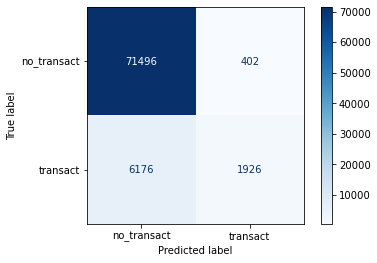

In [35]:
class_names = ['no_transact', 'transact']
plot_confusion_matrix(best_model, X_test, y_test,
                     display_labels=class_names,
                     cmap=plt.cm.Blues)

It look like for this particular problem, it is lowering top right but getting more errors of the bottum left type. 

### Checking some of the model details

In [23]:
trees_strings = model._Booster.get_dump(dump_format='text')
total_splits = 0
for tree_string in trees_strings:
    n_nodes = len(tree_string.split('\n')) - 1
    n_leaves = tree_string.count('leaf')
    total_splits += n_nodes - n_leaves
print("{0} splits in base model".format(total_splits))

trees_strings = best_model._Booster.get_dump(dump_format='text')
total_splits = 0
for tree_string in trees_strings:
    n_nodes = len(tree_string.split('\n')) - 1
    n_leaves = tree_string.count('leaf')
    total_splits += n_nodes - n_leaves
print("{0} splits in best model".format(total_splits))
  

5964 splits in base model
7090 splits in best model


# Feature Importance

In [50]:
%matplotlib inline

Basic Splits importance

<BarContainer object of 200 artists>

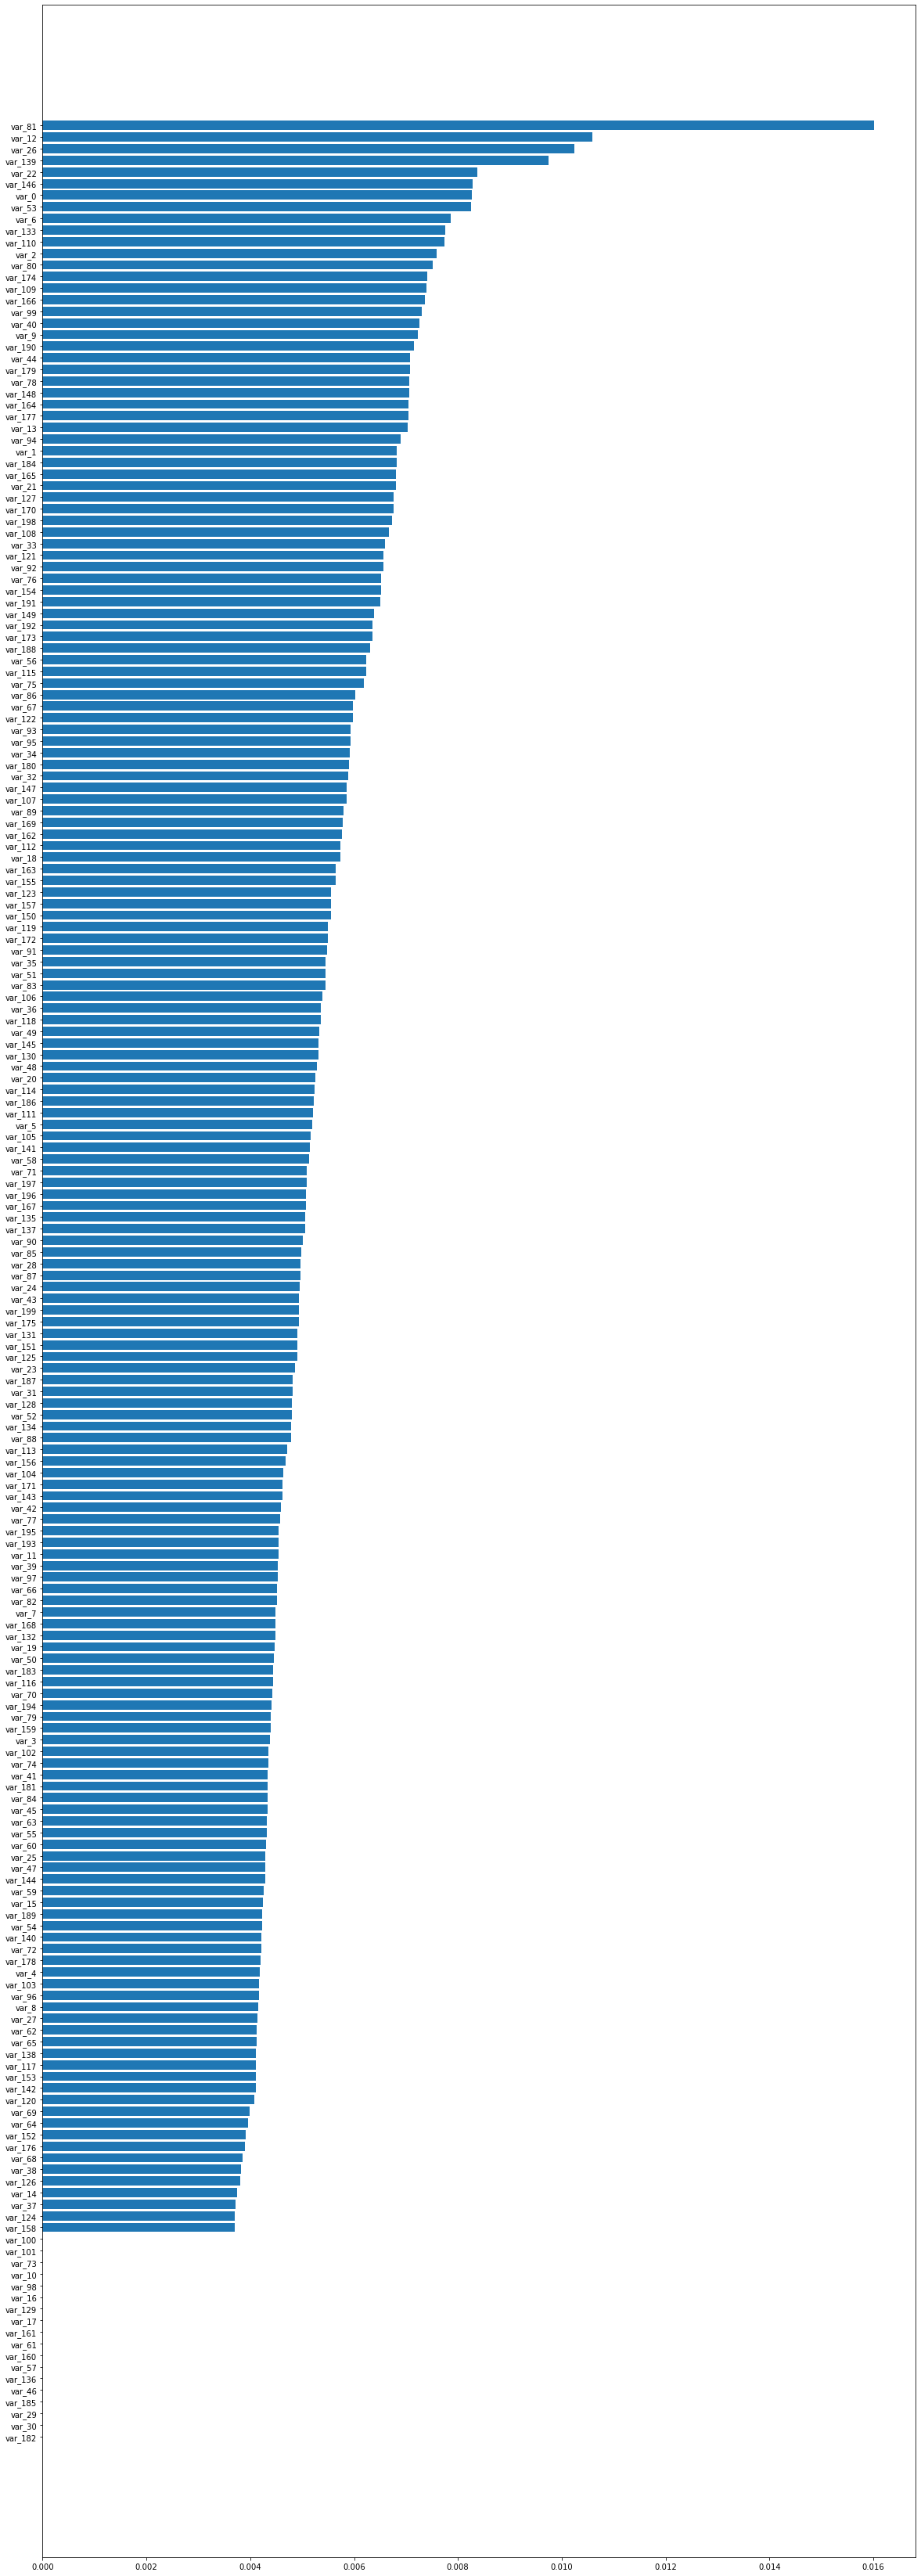

In [55]:
#fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sorted_idx = best_model.feature_importances_.argsort()
plt.rcParams["figure.figsize"]=20,60
plt.barh(ft_train.columns[sorted_idx], best_model.feature_importances_[sorted_idx])

Permutation Importance

In [56]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_model, X_test, y_test)

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()


Text(0.5, 0, 'Permutation Importance')

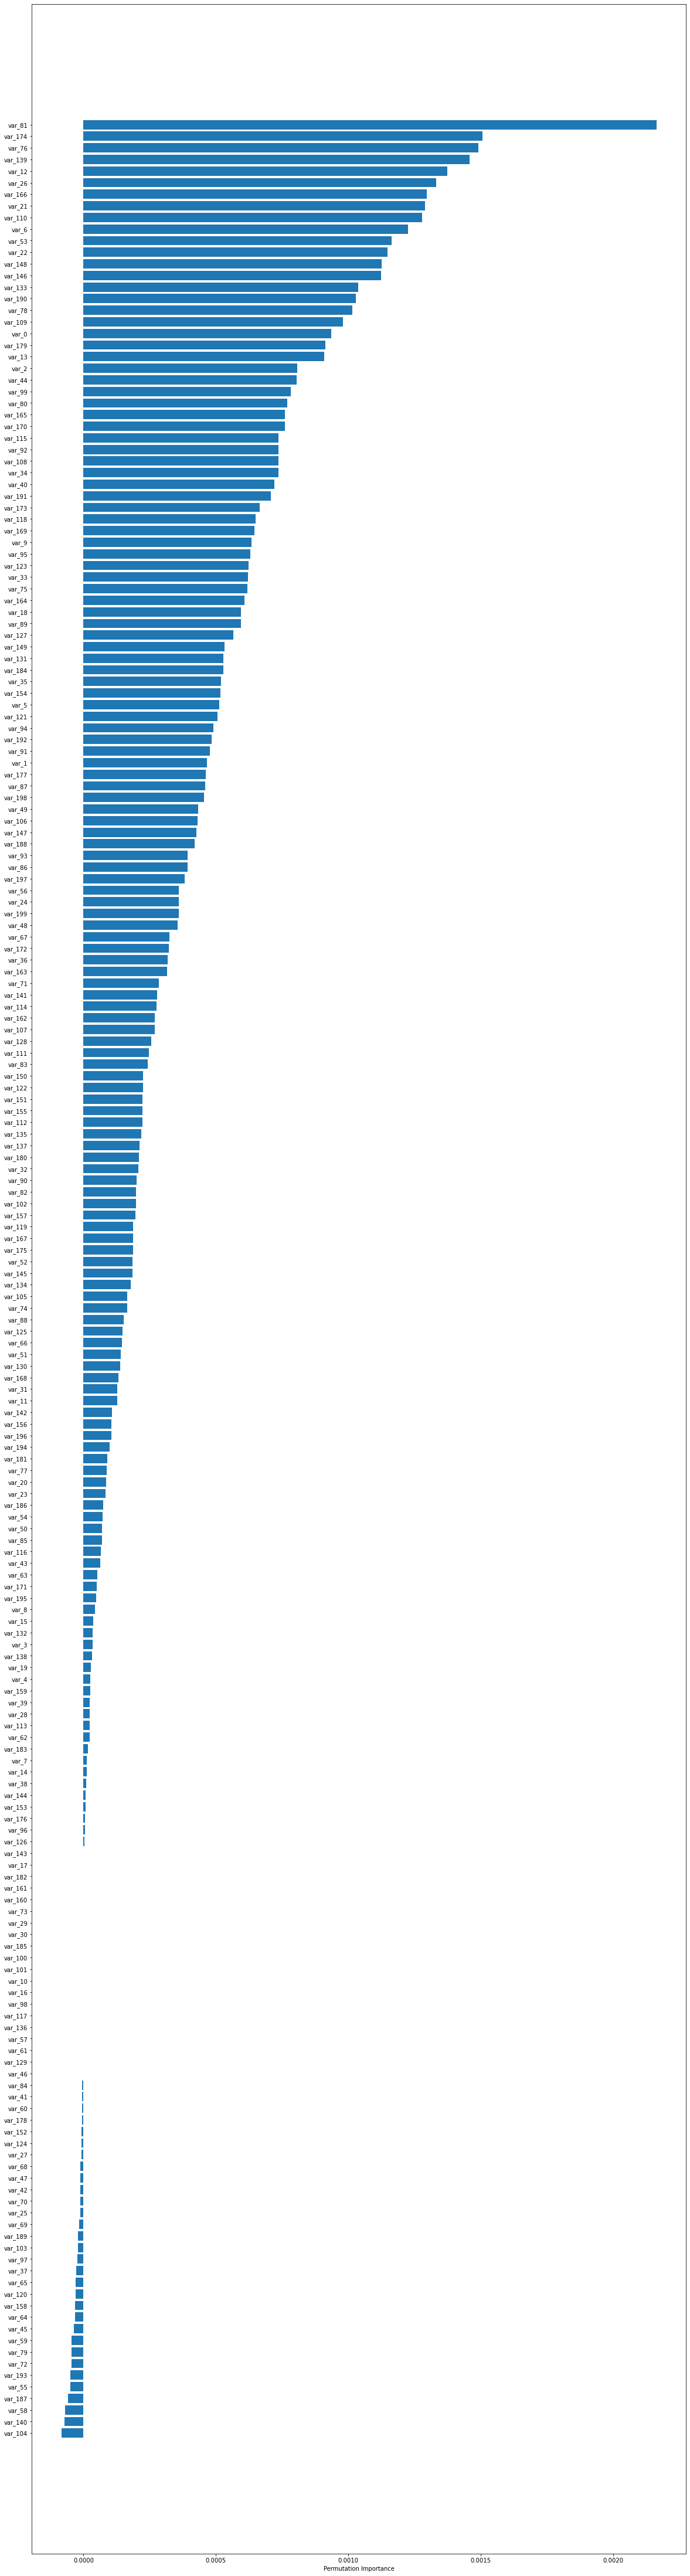

In [61]:
plt.rcParams["figure.figsize"]=20,80
plt.barh(ft_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

## Shap feature importance 

In [59]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.initjs()

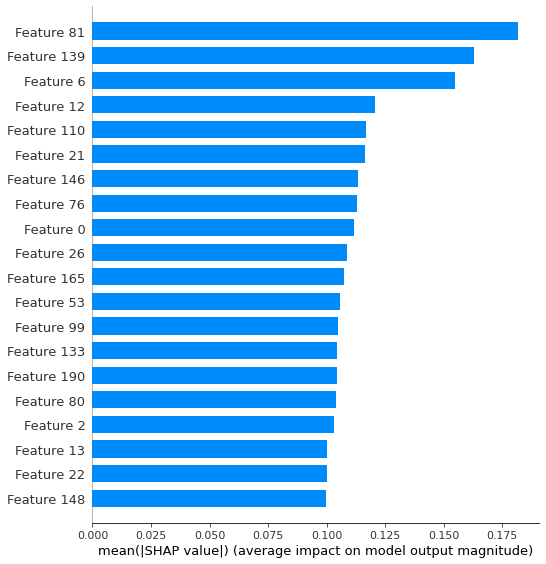

In [60]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

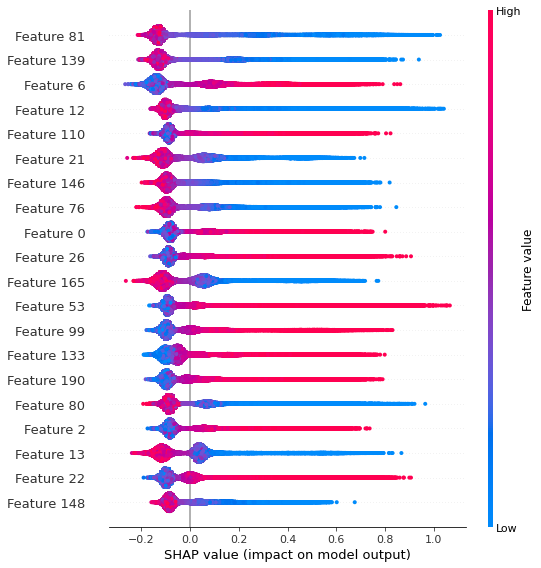

In [62]:
shap.summary_plot(shap_values, X_test)

In [76]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:], ft_train.columns)

## Lime Explanations

In [72]:
import lime
import lime.lime_tabular
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=ft_train.columns,
                                                       class_names=class_names, verbose=True,
                                                       mode='classification')

In [74]:
exp = lime_explainer.explain_instance(X_test[0], best_model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

Intercept 0.0661699253913473
Prediction_local [0.31279128]
Right: 0.0043164603
